# Forest Cover Type: Baseline Classification

For this project, we are working on predicting the forest cover type among 7 classifications based on cartographic variables from the US Geological Survey and USFS for each 30 x 30 meter cell of forest.

For more details, please see: https://www.kaggle.com/c/forest-cover-type-prediction

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# SK-learn libraries for learning.

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

# SK-Learn Libraries for feature tuning
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import KernelPCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

C:\Users\Storm\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Storm\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the training data. Note that kaggle has a separate file for test data which we will not load yet. Thus, we will split our training data into training and a dev set.

In [2]:
# Load full training data set
full_data = np.loadtxt("train.csv", dtype = "int", delimiter = ",", skiprows=1)
feature_names = np.loadtxt("train.csv", dtype = "str", delimiter = ",")[0,:]

# Split into data and labels
full_data_labels = full_data[:,full_data.shape[1]-1]
full_data = full_data[:,:full_data.shape[1]-1]
full_data = np.delete(full_data, 0, 1)  # Delete id to prevent use as feature

# features 20,21, and 28 have zero variance and can be removed for further analysis
full_data = np.delete(full_data, 28, 1)
full_data = np.delete(full_data, 21, 1)
full_data = np.delete(full_data, 20, 1)
feature_names = np.delete(feature_names,[28,21,20])

print ("full data shape: ", full_data.shape)
print ("full label shape:", full_data_labels.shape)
# Split into smaller training set and a dev set for us to use
# Shuffle the input so that we get a random subset in training vs dev
# Test set provided separately from kaggle where we do not know the labels
np.random.seed(58230)
shuffle = np.random.permutation(np.arange(full_data.shape[0]))
full_data, full_data_labels = full_data[shuffle], full_data_labels[shuffle]

train_data, train_labels = full_data[:14120], full_data_labels[:14120]
dev_data, dev_labels = full_data[14120:], full_data_labels[14120:]

print ("\ntrain data shape: ", train_data.shape)
print ("train label shape:", train_labels.shape)
print ("\ndev data shape: ", dev_data.shape)
print ("dev label shape:", dev_labels.shape)


# Print some basic info looking at a row of data
print("\nFeature names are:")
print(feature_names[1:-1])

print("\nAn example row of training data:")
print(train_data[0])

full data shape:  (15120, 51)
full label shape: (15120,)

train data shape:  (14120, 51)
train label shape: (14120,)

dev data shape:  (1000, 51)
dev label shape: (1000,)

Feature names are:
['Elevation' 'Aspect' 'Slope' 'Horizontal_Distance_To_Hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'Wilderness_Area1' 'Wilderness_Area2'
 'Wilderness_Area3' 'Wilderness_Area4' 'Soil_Type1' 'Soil_Type2'
 'Soil_Type3' 'Soil_Type4' 'Soil_Type5' 'Soil_Type8' 'Soil_Type9'
 'Soil_Type10' 'Soil_Type11' 'Soil_Type12' 'Soil_Type13' 'Soil_Type15'
 'Soil_Type16' 'Soil_Type17' 'Soil_Type18' 'Soil_Type19' 'Soil_Type20'
 'Soil_Type21' 'Soil_Type22' 'Soil_Type23' 'Soil_Type24' 'Soil_Type25'
 'Soil_Type26' 'Soil_Type27' 'Soil_Type28' 'Soil_Type29' 'Soil_Type30'
 'Soil_Type31' 'Soil_Type32' 'Soil_Type33' 'Soil_Type34' 'Soil_Type35'
 'Soil_Type36' 'Soil_Type37' 'Soil_Type38' 'Soil_Type39' 'Soil_T

In [3]:
scaler = preprocessing.StandardScaler()
continuous = scaler.fit_transform(train_data[:, range(0, 10)])
binary = train_data[:, range(10,51)]
scaled_train_data = np.concatenate((continuous, binary), axis=1)

con_dev = scaler.transform(dev_data[:, range(0, 10)])
bin_dev = dev_data[:, range(10,51)]
scaled_dev_data = np.concatenate((con_dev, bin_dev), axis=1)

selection=SelectKBest(k=25)  # just checking univariate selection method first
top_train=selection.fit_transform(scaled_train_data,train_labels)
top_dev=selection.transform(scaled_dev_data)

C:\Users\Storm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Run a basic logistic regression model.

In [4]:
# Run logistic regression with default values and check accuracy
model_log = LogisticRegression()
model_log.fit(train_data, train_labels)

print("Default logistic regression accuracy is %1.3f" % (model_log.score(dev_data,dev_labels)))

model_MN = LogisticRegression(class_weight='balanced',multi_class='multinomial',solver='saga',max_iter=250)
model_MN.fit(scaled_train_data, train_labels)

print("Multinomial logistic regression accuracy is %1.3f" % (model_MN.score(scaled_dev_data,dev_labels)))


reg_values = {'C': [ 1.0, 2.0, 3.0, 5.0, 10.0]}
modelLR = GridSearchCV(LogisticRegression(class_weight='balanced',multi_class='multinomial',solver='saga',max_iter=300,tol=0.001), reg_values)
modelLR.fit(scaled_train_data,train_labels)
print('Optimal C: ',modelLR.best_params_['C'])
print('Logistic Regression score with tuned C value: ',modelLR.best_estimator_.score(scaled_dev_data,dev_labels))


Default logistic regression accuracy is 0.679
Multinomial logistic regression accuracy is 0.721
Optimal C:  3.0
Logistic Regression score with tuned C value:  0.718


In [5]:
interactions = preprocessing.PolynomialFeatures(2)
poly_train=interactions.fit_transform(scaled_train_data)
poly_dev=interactions.transform(scaled_dev_data)
selection=SelectKBest(k=100)  
top_train=selection.fit_transform(poly_train,train_labels)
top_dev=selection.transform(poly_dev)

modelLR = LogisticRegression(penalty='l2',class_weight='balanced',multi_class='multinomial',solver='saga',max_iter=300,tol=0.001)
modelLR.fit(top_train,train_labels)

print('Logistic Regression score with top 100 features: ',modelLR.score(top_dev,dev_labels))

C:\Users\Storm\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [   0  518  519  520  521  522  523  524  525  526  528  529  531  532  534
  538  542  543  544  545  548  549  550  551  553  559  560  561  562  563
  564  565  566  567  568  569  570  572  573  574  575  578  583  584  585
  587  591  593  594  599  600  604  605  606  609  614  621  625  626  644
  647  648  652  653  654  655  656  657  658  659  660  661  662  663  664
  665  666  667  668  669  670  671  672  673  674  676  677  678  679  680
  681  682  683  684  685  686  687  688  689  690  691  692  693  694  695
  696  697  698  699  700  701  702  703  704  705  706  707  708  709  710
  711  713  714  715  716  717  718  719  720  721  722  723  724  725  726
  727  728  729  730  731  732  733  734  735  736  737  738  739  740  741
  742  743  744  745  746  747  749  750  751  752  753  754  755  756  757
  758  759  760  761  762  763  764  765  76

Logistic Regression score with top 100 features:  0.743


In [6]:
dt_clf = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt_clf.fit(train_data, train_labels)

print('Decision Tree accuracy:', dt_clf.score(dev_data, dev_labels))

rf_clf= RandomForestClassifier(n_estimators=250,max_features=10)
rf_clf.fit(train_data, train_labels)

print ('Random Forest accuracy:', rf_clf.score(dev_data, dev_labels))

importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(dev_data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Decision Tree accuracy: 0.801
Random Forest accuracy: 0.875
Feature ranking:
1. feature 0 (0.252690)
2. feature 5 (0.095526)
3. feature 9 (0.073919)
4. feature 3 (0.062194)
5. feature 4 (0.052329)
6. feature 6 (0.048846)
7. feature 1 (0.047673)
8. feature 13 (0.045329)
9. feature 8 (0.043786)
10. feature 7 (0.042370)
11. feature 2 (0.032310)
12. feature 21 (0.021250)
13. feature 48 (0.019544)
14. feature 16 (0.018313)
15. feature 10 (0.017803)
16. feature 49 (0.017314)
17. feature 12 (0.015543)
18. feature 17 (0.011998)
19. feature 50 (0.009819)
20. feature 40 (0.007272)
21. feature 15 (0.005701)
22. feature 27 (0.005081)
23. feature 24 (0.004757)
24. feature 32 (0.004710)
25. feature 42 (0.004669)
26. feature 33 (0.004410)
27. feature 39 (0.004392)
28. feature 23 (0.004188)
29. feature 43 (0.003114)
30. feature 11 (0.002934)
31. feature 22 (0.002769)
32. feature 19 (0.002555)
33. feature 34 (0.002155)
34. feature 45 (0.002132)
35. feature 41 (0.002036)
36. feature 14 (0.001572)
37. fe

In [7]:
imp_train = scaled_train_data[:, (0,5,9,3,4,6,1,13,8,7,2,21,48,16,49)] # most important features in random forest model
imp_dev = scaled_dev_data[:, (0,5,9,3,4,6,1,13,8,7,2,21,48,16,49)]

interactions = preprocessing.PolynomialFeatures(2)
i_train_X=interactions.fit_transform(imp_train)
i_dev_X=interactions.transform(imp_dev)

modelLR_L1 = LogisticRegression(penalty='l1',class_weight='balanced',multi_class='multinomial',solver='saga',max_iter=300,tol=0.001,C=0.15)
modelLR_L1.fit(i_train_X,train_labels)
print(modelLR_L1.score(i_dev_X,dev_labels))

0.744


In [8]:
#find which features have non zero weights
data = pd.DataFrame(modelLR_L1.coef_, columns=interactions.get_feature_names())
a = data.sum(axis=0)
for i in range((data.shape[1]-1),0,-1):
    if a[i] == 0:
        L2_train_X = np.delete(i_train_X, i, 1)
        L2_dev_X= np.delete(i_dev_X, i, 1)

In [9]:
modelLR_L2 = LogisticRegression(penalty='l2',class_weight='balanced',multi_class='multinomial',solver='saga',max_iter=400,tol=0.001,C=10.0)
modelLR_L2.fit(L2_train_X,train_labels)
print(modelLR_L2.score(L2_dev_X,dev_labels))

0.738


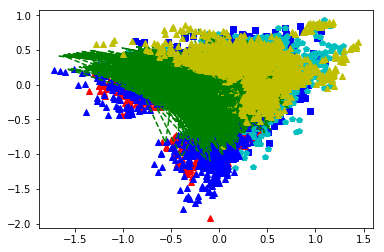

In [10]:
pca = KernelPCA(n_components=2,kernel="poly")
train_data_sm = pca.fit_transform(scaled_train_data)
full = pd.concat([pd.DataFrame(train_data_sm,columns=['c1', 'c2']),pd.DataFrame(train_labels,columns=['Tree'])]
                 , axis=1, ignore_index=False, levels=None, names=None) 
spruce = full[full.Tree == 1]
L_pine = full[full.Tree == 2]
P_pine = full[full.Tree == 3]
Willow = full[full.Tree == 4]
Aspen = full[full.Tree == 5]
fir = full[full.Tree == 6]
Krummholz = full[full.Tree == 7]

plt.plot(spruce.c1, spruce.c2, 'bs', fir.c1, fir.c2, 'r^',
         L_pine.c1, L_pine.c2, 'cp', P_pine.c1, P_pine.c2, 'b^',
         Aspen.c1, Aspen.c2, 'g--', Krummholz.c1, Krummholz.c2, 'y^',
        Willow.c1, Willow.c2, 'g--')